## Capstone Project - The Battle of the Neighborhoods

In this project we will classify locations in Mexico City using venue data from the Foursquare API.

We will classfiy locations per some neighborhoods.

The data used in this project was obtained from an [official page](https://datos.cdmx.gob.mx/pages/home/) of Mexico City

The database used is _"pgjcdmx.csv"_, which contains the Street Level Crime Investigation Folders for the first half of 2019.

* año_hechos: crime year
* mes_hechos: crime month
* fecha_hechos: crime date
* delito: specific crime
* categoria_delito: crime classification
* fiscalía: place of investigation
* agencia: agency where the investigation was conducted
* unidad_investigacion: investigation unit
* colonia_hechos: neighborhood where the crime occurred
* alcaldia_hechos: borough where the crime occurred
* fecha_inicio: investigation start date
* mes_inicio: investigation start month
* ao_inicio: investigation start year
* calle_hechos: street where the crime occurred
* calle_hechos2: second street where the crime occurred
* longitud: longitude of the crime
* latitud: latitude of the crime
* Geopoint: the latitude and longitude of the crime

#### Import necessary libraries

In [30]:
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Define credentials for Foursquare

In [31]:
CLIENT_ID = 'X1VRD52N1B5WCHUAHWI5N5M5ONLS5FTC113NQD2UUPBHN5XR'
CLIENT_SECRET = 'J5MZSEOXMEWMPNO1OU3MZ22XUHZAW54NTF5GYUD0UOENWGNY'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X1VRD52N1B5WCHUAHWI5N5M5ONLS5FTC113NQD2UUPBHN5XR
CLIENT_SECRET:J5MZSEOXMEWMPNO1OU3MZ22XUHZAW54NTF5GYUD0UOENWGNY


#### Loading the dataset

In [32]:
crimecdmx = pd.read_csv('pgjcdmx.csv')
crimecdmx.head()

,año_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalía,agencia,unidad_investigacion,colonia_hechos,alcaldia_hechos,fecha_inicio,mes_inicio,ao_inicio,calle_hechos,calle_hechos2,longitud,latitud,Geopoint
0,2019,Junio,2019-06-14 03:00:00,ROBO A NEGOCIO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,INVESTIGACIÓN EN IZTAPALAPA,IZP-3,UI-1SD,CENTRAL DE ABASTO,IZTAPALAPA,2019-06-14 06:48:12,Junio,2019,CASETA DE COBRO N10,AV DE LOS UNOS,-99.087182,19.368664,"19.3686642496,-99.087181672"
1,2019,Junio,2019-06-11 21:00:00,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN GUSTAVO A. MADERO,GAM-1,UI-3SD,FORESTAL I,GUSTAVO A MADERO,2019-06-14 10:32:42,Junio,2019,CALLE ACASIA,NaN,-99.130606,19.566454,"19.5664540094,-99.130606216"
2,2019,Junio,2019-06-13 20:00:00,ROBO A NEGOCIO SIN VIOLENCIA,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN TLALPAN,TLP-3,UI-3CD,PEÑA POBRE,TLALPAN,2019-06-14 11:03:48,Junio,2019,AVENIDA SAN FERNANDO,NaN,-99.181913,19.295461,"19.2954610994,-99.1819126002"
3,2019,Junio,2019-06-13 21:00:00,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN COYOACÁN,COY-4,UI-3CD,PEDREGAL DE SANTA URSULA,COYOACAN,2019-06-14 13:32:58,Junio,2019,SAN ISAURO,SAN RICARDO,-99.156086,19.311025,"19.3110251954,-99.1560859996"
4,2019,Junio,2019-06-11 14:00:00,FRAUDE,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN IZTAPALAPA,IZP-8,UI-3CD,JARDINES DE SAN LORENZO TEZONCO,IZTAPALAPA,2019-06-14 15:20:29,Junio,2019,JARDIN DALIAS,NaN,-99.072527,19.296230,"19.2962296035,-99.0725272001"


#### Some columns are redundant and will be dropped

In [33]:
crimecdmx.drop(['año_hechos', 'mes_hechos', 'fecha_hechos', 'delito', 'fiscalía', 'agencia', 'unidad_investigacion', 'fecha_inicio', 'mes_inicio', 'ao_inicio', 'calle_hechos', 'calle_hechos2', 'longitud', 'latitud', 'Geopoint'], axis=1, inplace=True)
crimecdmx.rename(columns={'categoria_delito': 'Categoria', 'colonia_hechos': 'Colonia', 'alcaldia_hechos': 'Alcaldia'}, inplace=True)
crimecdmx.head()

,Categoria,Colonia,Alcaldia
0,ROBO A NEGOCIO CON VIOLENCIA,CENTRAL DE ABASTO,IZTAPALAPA
1,DELITO DE BAJO IMPACTO,FORESTAL I,GUSTAVO A MADERO
2,DELITO DE BAJO IMPACTO,PEÑA POBRE,TLALPAN
3,DELITO DE BAJO IMPACTO,PEDREGAL DE SANTA URSULA,COYOACAN
4,DELITO DE BAJO IMPACTO,JARDINES DE SAN LORENZO TEZONCO,IZTAPALAPA


In [34]:
crimecdmx = crimecdmx[['Alcaldia', 'Colonia', 'Categoria']]
crimecdmx.head()

,Alcaldia,Colonia,Categoria
0,IZTAPALAPA,CENTRAL DE ABASTO,ROBO A NEGOCIO CON VIOLENCIA
1,GUSTAVO A MADERO,FORESTAL I,DELITO DE BAJO IMPACTO
2,TLALPAN,PEÑA POBRE,DELITO DE BAJO IMPACTO
3,COYOACAN,PEDREGAL DE SANTA URSULA,DELITO DE BAJO IMPACTO
4,IZTAPALAPA,JARDINES DE SAN LORENZO TEZONCO,DELITO DE BAJO IMPACTO


#### We will drop the entries with missing data.

In [35]:
crimecdmx = crimecdmx[crimecdmx['Colonia'].notna()]
crimecdmx[crimecdmx['Colonia'].isna()]

,Alcaldia,Colonia,Categoria


#### Total number of crimes in each Borough

In [36]:
X = crimecdmx.groupby('Alcaldia').count()
X.sort_values(['Categoria'], ascending = True, axis = 0, inplace = True )
X.reset_index(inplace=True)
X

,Alcaldia,Colonia,Categoria
0,NEZAHUALCOYOTL,1,1
1,NAUCALPAN DE JUAREZ,2,2
2,MILPA ALTA,715,715
3,CUAJIMALPA DE MORELOS,1674,1674
4,LA MAGDALENA CONTRERAS,1869,1869
5,TLAHUAC,2574,2574
6,XOCHIMILCO,3330,3330
7,IZTACALCO,5033,5033
8,AZCAPOTZALCO,5043,5043
9,TLALPAN,6320,6320


We will drop the first two Boroughs because they correspond to another State.

We will choose the best Borough to analyze based on the Boroughs with the least number of crimes. 

In [37]:
X.drop([0,1], axis=0, inplace=True)
Xh = X.head()
Xh

,Alcaldia,Colonia,Categoria
2,MILPA ALTA,715,715
3,CUAJIMALPA DE MORELOS,1674,1674
4,LA MAGDALENA CONTRERAS,1869,1869
5,TLAHUAC,2574,2574
6,XOCHIMILCO,3330,3330


We will choose Cuajimalpa de Morelos to analize based on a UN report that places it in the top 10 of the municipalities with the highest HDI in Mexico.

In [38]:
crimecuaji = crimecdmx[crimecdmx['Alcaldia'] == 'CUAJIMALPA DE MORELOS']
crimecuaji.drop(['Alcaldia'], axis=1, inplace=True)
print(crimecuaji.shape)
crimecuaji.head()

(1674, 2)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Colonia,Categoria
50,BOSQUES DE LAS LOMAS,DELITO DE BAJO IMPACTO
297,SAN JOSÉ DE LOS CEDROS,DELITO DE BAJO IMPACTO
350,EL ÉBANO,DELITO DE BAJO IMPACTO
478,SAN JOSÉ DE LOS CEDROS,DELITO DE BAJO IMPACTO
582,ZENTLAPATL,DELITO DE BAJO IMPACTO


#### Import necessary libraries to generate plots

In [39]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

We group the total crimes per Neighborhood and plot the Neighborhoods with the least number of crimes.

In [40]:
Y = crimecuaji.groupby('Colonia').count()
Y.rename(columns={'Categoria':'Total'}, inplace=True)
Y.sort_values(['Total'], ascending = True, axis = 0, inplace = True )
Y.reset_index(inplace=True)
Y

,Colonia,Total
0,1° DE MAYO,1
1,LOMAS DE SAN PEDRO,1
2,COLORINES,1
3,LOCAXCO,2
4,LAS MAROMAS,3
5,COLA DE PATO - PUEBLO,3
6,CLUB DE GOLF BOSQUES,3
7,MANZANASTITLA,4
8,AMADO NERVO,4
9,MEMETLA,5


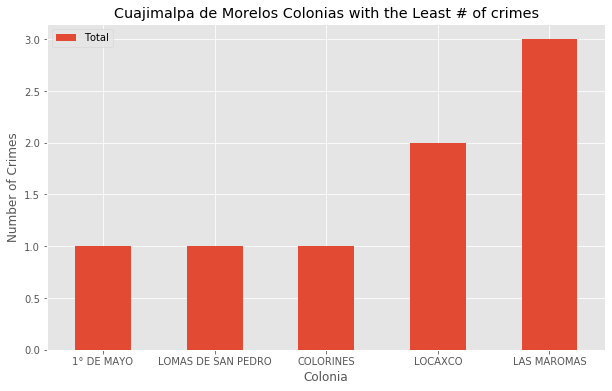

In [42]:
top5 = Y.head()

Ytop5 = top5[['Colonia','Total']]

Ytop5.set_index('Colonia',inplace = True)

ax = Ytop5.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Colonia') # add y-label to the plot
ax.set_title('Cuajimalpa de Morelos Colonias with the Least # of crimes') # add title to the plot

plt.show()

We plot the Neighborhoods with the highest number of crimes.

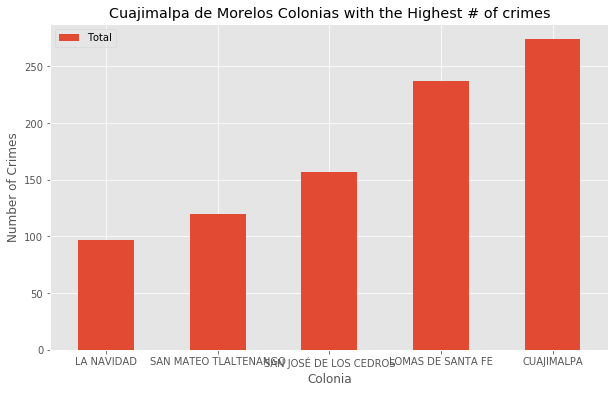

In [43]:
top5t = Y.tail()

Ytop5t = top5t[['Colonia','Total']]

Ytop5t.set_index('Colonia',inplace = True)

ax = Ytop5t.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Colonia') # add y-label to the plot
ax.set_title('Cuajimalpa de Morelos Colonias with the Highest # of crimes') # add title to the plot

plt.show()

We group the total crimes per Category and plot.

In [44]:
Z = crimecuaji.groupby('Categoria').count()
Z.rename(columns={'Colonia':'Total'}, inplace=True)
Z.reset_index(inplace=True)
Z

,Categoria,Total
0,DELITO DE BAJO IMPACTO,1477
1,HECHO NO DELICTIVO,18
2,HOMICIDIO DOLOSO,6
3,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,3
4,ROBO A CASA HABITACIÓN CON VIOLENCIA,6
5,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...,6
6,ROBO A NEGOCIO CON VIOLENCIA,27
7,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...,1
8,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,3
9,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,17


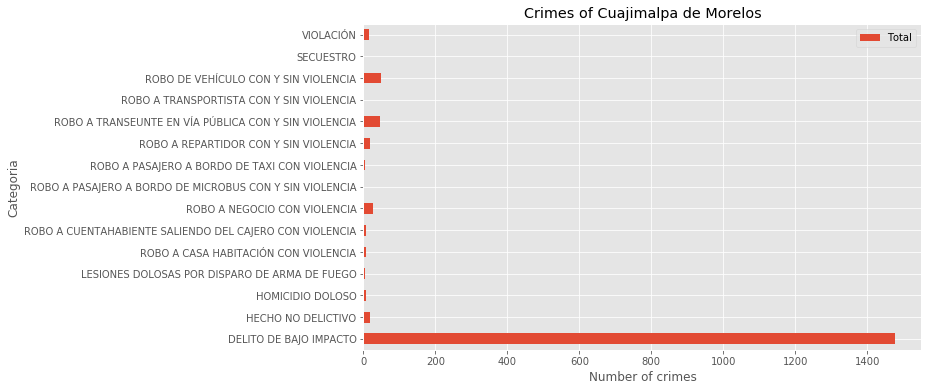

In [45]:
Zc = Z[['Categoria','Total']]

Zc.set_index('Categoria',inplace = True)

ax = Zc.plot(kind='barh', figsize=(10, 6), rot=0)

ax.set_ylabel('Categoria') # add to x-label to the plot
ax.set_xlabel('Number of crimes') # add y-label to the plot
ax.set_title('Crimes of Cuajimalpa de Morelos') # add title to the plot

plt.show()

We apply the "one hot encoding" and group to see the frequency of occurrence of crimes per Neighborhood in Cuajimalpa de Morelos.

In [46]:
# one hot encoding
crimecuaji_onehot = pd.get_dummies(crimecuaji[['Categoria']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
crimecuaji_onehot['Colonia'] = crimecuaji['Colonia'] 

# move neighborhood column to the first column
fixed_columns = [crimecuaji_onehot.columns[-1]] + list(crimecuaji_onehot.columns[:-1])
crimecuaji_onehot = crimecuaji_onehot[fixed_columns]

# frequency of occurrence
crimecuaji_grouped = crimecuaji_onehot.groupby('Colonia').mean().reset_index()

crimecuaji_grouped.head()

,Colonia,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACIÓN
0,1° DE MAYO,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0
1,ABDIAS GARCIA SOTO,0.857143,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.071429,0.0,0.0
2,ADOLFO LÓPEZ MATEOS,0.750000,0.125000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.000000,0.0,0.0
3,AGUA BENDITA,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0
4,AHUATENCO,0.952381,0.000000,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0


#### Creating a new dataset of the Neighborhoods in Cuajimalpa de Morelos and generating their coordinates

In [47]:
Y['Colonia'].unique()

array(['1° DE MAYO', 'LOMAS DE SAN PEDRO', 'COLORINES', 'LOCAXCO',
       'LAS MAROMAS', 'COLA DE PATO - PUEBLO', 'CLUB DE GOLF BOSQUES',
       'MANZANASTITLA', 'AMADO NERVO', 'MEMETLA', 'LOMA DEL OCOTE',
       'EL MOLINO', 'SANTA ROSA XOCHIAC', 'EL MOLINITO',
       'ADOLFO LÓPEZ MATEOS', 'TEPETONGO', 'AGUA BENDITA',
       'ABDIAS GARCIA SOTO', 'CRUZ BLANCA', 'EL ÉBANO', 'EL YAQUI',
       'XALPA', 'LAS LAJAS', 'JESÚS DEL MONTE', 'AHUATENCO',
       'LAS TINAJAS', 'JARDINES DE LA PALMA', 'LOMAS DE MEMETLA',
       'LA PILA', 'CONTADERO', 'SAN PABLO CHIMALPA', 'LA ROSITA',
       'PALO ALTO', 'BOSQUES DE LAS LOMAS', 'LOMAS DEL CHAMIZAL',
       'LOMAS DE VISTA HERMOSA', 'SAN LORENZO ACOPILCO', 'ZENTLAPATL',
       'LA NAVIDAD', 'SAN MATEO TLALTENANGO', 'SAN JOSÉ DE LOS CEDROS',
       'LOMAS DE SANTA FE', 'CUAJIMALPA'], dtype=object)

In [48]:
Colonia = ['LOMAS DE SAN PEDRO', 'COLORINES', 'LOCAXCO',
       'LAS MAROMAS', 'COLA DE PATO',
       'MANZANASTITLA', 'AMADO NERVO', 'MEMETLA',
       'SANTA ROSA XOCHIAC', 'EL MOLINITO',
       'AGUA BENDITA', 'ABDIAS GARCIA SOTO', 'EL ÉBANO', 'EL YAQUI',
       'XALPA', 'LAS LAJAS', 'JESÚS DEL MONTE', 'AHUATENCO',
       'LAS TINAJAS', 'JARDINES DE LA PALMA', 'LOMAS DE MEMETLA',
       'LA PILA', 'CONTADERO', 'LA ROSITA',
       'PALO ALTO', 'BOSQUES DE LAS LOMAS', 'LOMAS DEL CHAMIZAL',
       'LOMAS DE VISTA HERMOSA', 'SAN LORENZO ACOPILCO',
       'LA NAVIDAD', 'SAN MATEO TLALTENANGO', 'SAN JOSÉ DE LOS CEDROS',
       'LOMAS DE SANTA FE', 'CUAJIMALPA']

Latitude = ['','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']

df_col = {'Colonia': Colonia,'Latitude': Latitude,'Longitude':Longitude}
df_cuaji = pd.DataFrame(data=df_col, columns=['Colonia', 'Latitude', 'Longitude'], index=None)

df_cuaji.head()

,Colonia,Latitude,Longitude
0,LOMAS DE SAN PEDRO,,
1,COLORINES,,
2,LOCAXCO,,
3,LAS MAROMAS,,
4,COLA DE PATO,,


Find the coordinates of each Neighborhood

In [49]:
Latitude = []
Longitude = []

for i in range(len(Colonia)):
    address = '{},CDMX'.format(Colonia[i])
    geolocator = Nominatim(user_agent="MexicoCity_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[19.3541386, 19.3682157, 19.3551831, 19.3276764, 19.3070188, 19.3664382, 19.3682746, 19.3603464, 19.3263625, 19.3614778, 19.3600545, 19.3517289, 19.3732186, 19.3597557, 19.311017, 19.3158505, 19.3650389, 19.3687209, 19.3560072, 19.3707509, 19.357515, 19.3134288, 19.3490881, 19.3631349, 19.3866243, 19.403526, 19.398299, 19.3763411, 19.3298013, 19.3744282, 19.3335318, 19.3675408, 19.3860225, 19.3570477] [-99.2879586, -99.2845954, -99.2907934, -99.3331193, -99.3392421, -99.2991828, -99.2984577, -99.2868884, -99.28753, -99.287066, -99.3036825, -99.2926828, -99.289308, -99.2838552, -99.3297876, -99.3338518, -99.2919906, -99.3053223, -99.2836537, -99.281087, -99.2879415, -99.3366151, -99.2925163, -99.277228, -99.2506974, -99.2454929, -99.25882, -99.2693225, -99.3274119, -99.2841379, -99.2820522, -99.2890279, -99.2402772, -99.3006776]


In [50]:
df_col = {'Colonia': Colonia,'Latitude': Latitude,'Longitude':Longitude}
df_cuaji = pd.DataFrame(data=df_col, columns=['Colonia', 'Latitude', 'Longitude'], index=None)
df_cuaji

,Colonia,Latitude,Longitude
0,LOMAS DE SAN PEDRO,19.354139,-99.287959
1,COLORINES,19.368216,-99.284595
2,LOCAXCO,19.355183,-99.290793
3,LAS MAROMAS,19.327676,-99.333119
4,COLA DE PATO,19.307019,-99.339242
5,MANZANASTITLA,19.366438,-99.299183
6,AMADO NERVO,19.368275,-99.298458
7,MEMETLA,19.360346,-99.286888
8,SANTA ROSA XOCHIAC,19.326362,-99.287530
9,EL MOLINITO,19.361478,-99.287066


Get the coordinates of Cuajimalpa de Morelos, CDMX

In [51]:
address =  'Cuajimalpa de Morelos, CDMX'

geolocator = Nominatim(user_agent="Cuaji_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cuajimalpa de Morelos are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cuajimalpa de Morelos are 19.3187067, -99.32320297716439.


Visualize Cuajimalpa de Morelos

In [52]:
# create map of Cuajimalpa de Morelos using latitude and longitude values
cuaji_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_cuaji['Latitude'], df_cuaji['Longitude'], df_cuaji['Colonia']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cuaji_map)  
    
cuaji_map

#### Create a function to extract the venues from each Neighborhood

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Colonia', 
                  'Colonia Latitude', 
                  'Colonia Longitude', 
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
cuaji_venues = getNearbyVenues(names=df_cuaji['Colonia'],
                                   latitudes=df_cuaji['Latitude'],
                                   longitudes=df_cuaji['Longitude']
                                  )

LOMAS DE SAN PEDRO
COLORINES
LOCAXCO
LAS MAROMAS
COLA DE PATO
MANZANASTITLA
AMADO NERVO
MEMETLA
SANTA ROSA XOCHIAC
EL MOLINITO
AGUA BENDITA
ABDIAS GARCIA SOTO
EL ÉBANO
EL YAQUI
XALPA
LAS LAJAS
JESÚS DEL MONTE
AHUATENCO
LAS TINAJAS
JARDINES DE LA PALMA
LOMAS DE MEMETLA
LA PILA
CONTADERO
LA ROSITA
PALO ALTO
BOSQUES DE LAS LOMAS
LOMAS DEL CHAMIZAL
LOMAS DE VISTA HERMOSA
SAN LORENZO ACOPILCO
LA NAVIDAD
SAN MATEO TLALTENANGO
SAN JOSÉ DE LOS CEDROS
LOMAS DE SANTA FE
CUAJIMALPA


In [55]:
print(cuaji_venues.shape)
cuaji_venues.head()

(525, 7)


,Colonia,Colonia Latitude,Colonia Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,LOMAS DE SAN PEDRO,19.354139,-99.287959,Pizza y Subs 997,19.353752,-99.291014,Pizza Place
1,LOMAS DE SAN PEDRO,19.354139,-99.287959,Kekas La Tía Ana,19.353270,-99.286796,Mexican Restaurant
2,LOMAS DE SAN PEDRO,19.354139,-99.287959,Dive Encounters,19.355141,-99.291436,Dive Shop
3,LOMAS DE SAN PEDRO,19.354139,-99.287959,Central Hamburguesas +carbon,19.353868,-99.291070,Burger Joint
4,LOMAS DE SAN PEDRO,19.354139,-99.287959,Mercado del Domingo,19.351484,-99.284865,Cheese Shop


In [56]:
#Let's check how many venues were returned for each neighborhood
cuaji_venues.groupby('Colonia').count()

,Colonia Latitude,Colonia Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Colonia,,,,,,
ABDIAS GARCIA SOTO,9,9,9,9,9,9
AGUA BENDITA,4,4,4,4,4,4
AHUATENCO,1,1,1,1,1,1
AMADO NERVO,5,5,5,5,5,5
BOSQUES DE LAS LOMAS,41,41,41,41,41,41
COLA DE PATO,3,3,3,3,3,3
COLORINES,14,14,14,14,14,14
CONTADERO,4,4,4,4,4,4
CUAJIMALPA,23,23,23,23,23,23


In [57]:
# one hot encoding
cuaji_onehot = pd.get_dummies(cuaji_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cuaji_onehot['Colonia'] = cuaji_venues['Colonia'] 

# move neighborhood column to the first column
fixed_columns = [cuaji_onehot.columns[-1]] + list(cuaji_onehot.columns[:-1])
cuaji_onehot = cuaji_onehot[fixed_columns]

#Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
cuaji_grouped = cuaji_onehot.groupby('Colonia').mean().reset_index()
cuaji_grouped.shape

cuaji_grouped

,Colonia,ATM,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beer Garden,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Campground,Candy Store,Car Wash,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Donut Shop,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Garden,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,History Museum,Hotel,Housing Development,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Laundromat,Liquor Store,Lounge,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Mountain,Movie Theater,Moving Target,Multiplex,New American Restaurant,Nightclub,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Perfume Shop,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Pool Hall,Pub,Residential Building (Apartment / Condo),Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tea Room,Town,Toy / Game Store,Venezuelan Restaurant,Video Game Store,Wings Joint,Women's Store,Yoga Studio
0,ABDIAS GARCIA SOTO,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.000000,0.000000,0.111111,0.000000,0.0000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,AGUA BENDITA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,AHUATENCO,0.0,0.000000,0.0

In [58]:
num_top_venues = 5

for hood in cuaji_grouped['Colonia']:
    print("----"+hood+"----")
    temp = cuaji_grouped[cuaji_grouped['Colonia'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ABDIAS GARCIA SOTO----
                venue  freq
0         Pizza Place  0.22
1          Taco Place  0.11
2        Burger Joint  0.11
3       Shopping Mall  0.11
4  Mexican Restaurant  0.11


----AGUA BENDITA----
                   venue  freq
0             Taco Place  0.50
1               Gym Pool  0.25
2            Pizza Place  0.25
3  Outdoors & Recreation  0.00
4          Moving Target  0.00


----AHUATENCO----
           venue  freq
0         Lounge   1.0
1            ATM   0.0
2  Movie Theater   0.0
3       Pie Shop   0.0
4      Piano Bar   0.0


----AMADO NERVO----
                  venue  freq
0                   ATM   0.2
1              Bus Stop   0.2
2  Other Great Outdoors   0.2
3              Mountain   0.2
4        Gymnastics Gym   0.2


----BOSQUES DE LAS LOMAS----
              venue  freq
0  Sushi Restaurant  0.07
1    Ice Cream Shop  0.07
2        Food Truck  0.05
3            Bakery  0.05
4       Coffee Shop  0.05


----COLA DE PATO----
                   venue  

In [59]:
#Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Display the top 10 venues for each colonia
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Colonia']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
colonias_venues_sorted = pd.DataFrame(columns=columns)
colonias_venues_sorted['Colonia'] = cuaji_grouped['Colonia']

for ind in np.arange(cuaji_grouped.shape[0]):
    colonias_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cuaji_grouped.iloc[ind, :], num_top_venues)

colonias_venues_sorted.head()

,Colonia,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABDIAS GARCIA SOTO,Pizza Place,Mexican Restaurant,Soccer Field,Gym,Dive Shop,Burger Joint,Taco Place,Shopping Mall,Dessert Shop,Discount Store
1,AGUA BENDITA,Taco Place,Pizza Place,Gym Pool,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Electronics Store,Dance Studio
2,AHUATENCO,Lounge,Yoga Studio,Farm,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store
3,AMADO NERVO,Gymnastics Gym,Other Great Outdoors,Bus Stop,Mountain,ATM,Toy / Game Store,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop
4,BOSQUES DE LAS LOMAS,Ice Cream Shop,Sushi Restaurant,Bakery,Coffee Shop,Restaurant,Tea Room,Food Truck,Seafood Restaurant,Juice Bar,Road


Now we can visualize the top 10 categories for some Neighborhoods

#### Clustering Neighborhoods

In [60]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

cuaji_grouped_clustering = cuaji_grouped.drop('Colonia', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cuaji_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 2, 4, 1, 0, 1, 1, 1, 0], dtype=int32)

In [61]:
# add clustering labels
colonias_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cuaji_merged = df_cuaji

# merge cuaji_grouped with df_cuaji to add latitude/longitude for each neighborhood
cuaji_merged = cuaji_merged.join(colonias_venues_sorted.set_index('Colonia'), on='Colonia')

cuaji_merged.head() # check the last columns!

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LOMAS DE SAN PEDRO,19.354139,-99.287959,0,Mexican Restaurant,Gym,Taco Place,Cheese Shop,Shopping Mall,Convenience Store,Dive Shop,Steakhouse,Burger Joint,Lounge
1,COLORINES,19.368216,-99.284595,1,Gym,Sports Club,Pizza Place,Restaurant,Mexican Restaurant,Seafood Restaurant,Convenience Store,Farmers Market,Fish & Chips Shop,Japanese Restaurant
2,LOCAXCO,19.355183,-99.290793,0,Mexican Restaurant,Pizza Place,Taco Place,Burger Joint,Shopping Mall,Soccer Field,Coffee Shop,Dive Shop,Lounge,Seafood Restaurant
3,LAS MAROMAS,19.327676,-99.333119,3,Taco Place,Coffee Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Dance Studio,Farm,Deli / Bodega
4,COLA DE PATO,19.307019,-99.339242,0,Food Truck,Mexican Restaurant,Bus Station,Yoga Studio,Dive Shop,Discount Store,Diner,Dessert Shop,Department Store,Electronics Store


#### Visualize the clusters

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cuaji_merged['Latitude'], cuaji_merged['Longitude'], cuaji_merged['Colonia'], cuaji_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

#### Analysis

In [63]:
cuaji_merged[cuaji_merged['Cluster Labels'] == 0]

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LOMAS DE SAN PEDRO,19.354139,-99.287959,0,Mexican Restaurant,Gym,Taco Place,Cheese Shop,Shopping Mall,Convenience Store,Dive Shop,Steakhouse,Burger Joint,Lounge
2,LOCAXCO,19.355183,-99.290793,0,Mexican Restaurant,Pizza Place,Taco Place,Burger Joint,Shopping Mall,Soccer Field,Coffee Shop,Dive Shop,Lounge,Seafood Restaurant
4,COLA DE PATO,19.307019,-99.339242,0,Food Truck,Mexican Restaurant,Bus Station,Yoga Studio,Dive Shop,Discount Store,Diner,Dessert Shop,Department Store,Electronics Store
7,MEMETLA,19.360346,-99.286888,0,Mexican Restaurant,Taco Place,Coffee Shop,Gym / Fitness Center,Convenience Store,Farmers Market,Car Wash,Diner,Burger Joint,Food & Drink Shop
9,EL MOLINITO,19.361478,-99.287066,0,Mexican Restaurant,Taco Place,Coffee Shop,Sports Club,Food & Drink Shop,Farmers Market,Convenience Store,Pet Store,Car Wash,Burger Joint
11,ABDIAS GARCIA SOTO,19.351729,-99.292683,0,Pizza Place,Mexican Restaurant,Soccer Field,Gym,Dive Shop,Burger Joint,Taco Place,Shopping Mall,Dessert Shop,Discount Store
12,EL ÉBANO,19.373219,-99.289308,0,Taco Place,Mexican Restaurant,Breakfast Spot,Farmers Market,Restaurant,Beer Garden,Bar,Convenience Store,Pizza Place,Gym
16,JESÚS DEL MONTE,19.365039,-99.291991,0,Mexican Restaurant,Taco Place,Convenience Store,Pet Store,Shopping Mall,Dance Studio,Bus Stop,Soccer Field,Soccer Stadium,Food & Drink Shop
20,LOMAS DE MEMETLA,19.357515,-99.287942,0,Mexican Restaurant,Gym,Coffee Shop,Lounge,Diner,Dive Shop,Japanese Restaurant,Shopping Mall,Cycle Studio,Farmers Market
26,LOMAS DEL CHAMIZAL,19.398299,-99.258820,0,Mexican Restaurant,Taco Place,Convenience Store,Salon / Barbershop,Shopping Mall,Coffee Shop,Ice Cream Shop,Cycle Studio,Dance Studio,Cupcake Shop


This cluster is one of the biggest and contains a great diversity of venues.

In [64]:
cuaji_merged[cuaji_merged['Cluster Labels'] == 1]

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,COLORINES,19.368216,-99.284595,1,Gym,Sports Club,Pizza Place,Restaurant,Mexican Restaurant,Seafood Restaurant,Convenience Store,Farmers Market,Fish & Chips Shop,Japanese Restaurant
8,SANTA ROSA XOCHIAC,19.326362,-99.287530,1,Taco Place,Burger Joint,Plaza,Diner,Dance Studio,Discount Store,Dessert Shop,Department Store,Deli / Bodega,Yoga Studio
13,EL YAQUI,19.359756,-99.283855,1,Spa,Gym,Gym / Fitness Center,Coffee Shop,Diner,Taco Place,Hotel,Yoga Studio,Construction & Landscaping,Cycle Studio
14,XALPA,19.311017,-99.329788,1,Bar,Campground,Basketball Court,Taco Place,Yoga Studio,Donut Shop,Dive Shop,Discount Store,Diner,Dessert Shop
18,LAS TINAJAS,19.356007,-99.283654,1,Coffee Shop,Gym,Taco Place,Japanese Restaurant,Cycle Studio,Café,Restaurant,Diner,Mexican Restaurant,Construction & Landscaping
19,JARDINES DE LA PALMA,19.370751,-99.281087,1,Pizza Place,Pharmacy,Paper / Office Supplies Store,Bar,Grocery Store,Gym / Fitness Center,Fast Food Restaurant,Comfort Food Restaurant,Park,Pet Store
21,LA PILA,19.313429,-99.336615,1,Department Store,Basketball Court,Moving Target,River,Bakery,Dive Shop,Discount Store,Diner,Dessert Shop,Yoga Studio
22,CONTADERO,19.349088,-99.292516,1,Pizza Place,Shopping Mall,Fast Food Restaurant,Gym,Asian Restaurant,Construction & Landscaping,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio
23,LA ROSITA,19.363135,-99.277228,1,Gym,Coffee Shop,Restaurant,Breakfast Spot,Cosmetics Shop,Shopping Mall,Mexican Restaurant,Hotel,Department Store,Furniture / Home Store
24,PALO ALTO,19.386624,-99.250697,1,Coffee Shop,Restaurant,Hotel,Ice Cream Shop,Japanese Restaurant,Nightclub,Bakery,Gymnastics Gym,Comfort Food Restaurant,Playground


The second cluster is as big as the first and also contains a great diversity of venues.

In [65]:
cuaji_merged[cuaji_merged['Cluster Labels'] == 2]

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,AHUATENCO,19.368721,-99.305322,2,Lounge,Yoga Studio,Farm,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store


This cluster has one Neighborhood which consists of Venues related to personal care.

In [66]:
cuaji_merged[cuaji_merged['Cluster Labels'] == 3]

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,LAS MAROMAS,19.327676,-99.333119,3,Taco Place,Coffee Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Dance Studio,Farm,Deli / Bodega
10,AGUA BENDITA,19.360055,-99.303682,3,Taco Place,Pizza Place,Gym Pool,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Cycle Studio,Electronics Store,Dance Studio
15,LAS LAJAS,19.315850,-99.333852,3,Taco Place,River,Diner,Dance Studio,Basketball Court,Yoga Studio,Dive Shop,Discount Store,Dessert Shop,Department Store
28,SAN LORENZO ACOPILCO,19.329801,-99.327412,3,Taco Place,Pie Shop,Outdoors & Recreation,Soccer Stadium,Coffee Shop,Coworking Space,Cosmetics Shop,Cupcake Shop,Convenience Store,Dive Shop
30,SAN MATEO TLALTENANGO,19.333532,-99.282052,3,Taco Place,Farm,Deli / Bodega,Donut Shop,Dive Shop,Discount Store,Diner,Dessert Shop,Department Store,Yoga Studio


This cluster is similar to the previous one but also contains restaurants.

In [67]:
cuaji_merged[cuaji_merged['Cluster Labels'] == 4]

,Colonia,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,MANZANASTITLA,19.366438,-99.299183,4,Gymnastics Gym,Soccer Stadium,Restaurant,Soccer Field,ATM,Toy / Game Store,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop
6,AMADO NERVO,19.368275,-99.298458,4,Gymnastics Gym,Other Great Outdoors,Bus Stop,Mountain,ATM,Toy / Game Store,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop


This cluster is dominated by venues related to sports.